In [15]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
import numpy as np
import pandas as pd

def calculate_cardiac_indices(df):
    """
    Calculate cardiac indices based on available variables for either clinical or computational datasets.
    """

    # Try to find LVIDd column
    if 'LVIDd' in df.columns:
        LVIDd_col = 'LVIDd'
        LVIDs_col = 'LVIDs'
        LVEF_col = 'LVEF_tte'
        NIBPd_col = 'NIBPd_vitals'
        NIBPs_col = 'NIBPs_vitals'
        PCW_col = 'PCW'
        RAm_col = 'RAm'
        CO_col = 'CO_fick'
        PAs_col = 'PAs'
        PAd_col = 'PAd'
        IVSd_col = 'IVSd'
        Height_col = 'Height'
        Weight_col = 'Weight'
    else:
        # Assume computational dataset uses _S suffix
        LVIDd_col = 'LVIDd_S'
        LVIDs_col = 'LVIDs_S'
        LVEF_col = 'EF_S'
        NIBPd_col = 'DBP_S'
        NIBPs_col = 'SBP_S'
        PCW_col = 'PCWP_S'
        RAm_col = 'RAPmean_S'
        CO_col = 'CO_S'
        PAs_col = 'PASP_S'
        PAd_col = 'PADP_S'
        IVSd_col = 'IVSd_S' if 'IVSd_S' in df.columns else LVIDs_col  # fallback
        Height_col = 'Height' if 'Height' in df.columns else None
        Weight_col = 'Weight' if 'Weight' in df.columns else None

    # Calculate LVIDd in cm and LVEDV
    df['LVIDd_cm'] = df[LVIDd_col] / 10
    df['LVEDV'] = (4 / 3) * np.pi * (df['LVIDd_cm'] / 2) ** 3

    # LVEF as fraction
    df['LVEF_frac'] = df[LVEF_col] * 0.01

    # Stroke Volume
    df['LVSV'] = df['LVEDV'] * df['LVEF_frac']

    # Mean BP
    df['mean_BP'] = (2 / 3 * df[NIBPd_col]) + (1 / 3 * df[NIBPs_col])

    # BSA
    if Height_col and Weight_col:
        df['BSA'] = 0.007184 * (df[Weight_col] ** 0.425) * (df[Height_col] ** 0.725)
    else:
        df['BSA'] = 1.8  # default average if not provided

    # LVSWI
    df['LVSWI'] = df['LVSV'] * (df['mean_BP'] - df[PCW_col]) * 0.0136 / df['BSA']

    # RVSWI
    df['PAm'] = (df[PAs_col] + 2 * df[PAd_col]) / 3
    df['RVSWI_calc'] = df['LVSV'] * (df['PAm'] - df[RAm_col]) * 0.0136 / df['BSA']

    # LV stiffness
    df['stress'] = df[PCW_col] * (df['LVIDd_cm'] / 2) / (2 * df[IVSd_col])
    df['strain'] = (df['LVIDd_cm'] - df[LVIDs_col]) / df[LVIDs_col]
    df['LV_stiffness'] = df['stress'] / df['strain']

    # Passive CI
    df['Passive_Cardiac_Index'] = df[RAm_col] * df[CO_col] / (df[PCW_col] * df['BSA'])

    return df



In [12]:
def preprocess_data(csv_file):
    data = pd.read_csv(csv_file)
    data = data.dropna(subset=['RV Dysfunction'])
    data = data[data['RV Dysfunction'] != '0']

    if 'Birthday' in data.columns:
        data['Birthday'] = pd.to_datetime(data['Birthday'], format="%d-%b-%y", errors='coerce')
        data = data.dropna(subset=['Birthday'])
        today = pd.to_datetime('today')
        data['Age'] = (today - data['Birthday']).dt.days / 365.25
        data = data.drop(columns=['Birthday'], errors='ignore')

    data = calculate_cardiac_indices(data)
    missing_percentages = data.isnull().mean() * 100
    data = data.drop(columns=missing_percentages[missing_percentages > 20].index)
    data = data[data.isnull().mean(axis=1) <= 0.2].reset_index(drop=True)

    return data

In [16]:
def perform_t_tests(df, label):
    print(f"\n--- T-Test Results for {label} ---")
    df = df.copy()
    df['RV Group'] = df['RV Dysfunction'].replace({
        'Moderate': 'High', 'Severe': 'High', 'Normal': 'Low', 'Mild': 'Low'
    })
    num_cols = df.select_dtypes(include=[np.number]).columns
    for col in num_cols:
        try:
            high = df[df['RV Group'] == 'High'][col].dropna()
            low = df[df['RV Group'] == 'Low'][col].dropna()
            if len(high) > 1 and len(low) > 1:
                stat, p = ttest_ind(high, low, equal_var=False)
                if p < 0.05:
                    print(f"{col}: p = {p:.4f} (significant)")
        except:
            continue


In [18]:
def plot_boxplot(df, feature, label):
    df = df.copy()
    df['RV Group'] = df['RV Dysfunction'].replace({
        'Moderate': 'High', 'Severe': 'High', 'Normal': 'Low', 'Mild': 'Low'
    })
    plt.figure(figsize=(6, 4))
    sns.boxplot(x='RV Group', y=feature, data=df)
    plt.title(f'{feature} by RV Group - {label}')
    plt.tight_layout()
    plt.show()

In [19]:
def plot_ttest_pvalues(df, label):
    df = df.copy()
    df['RV Group'] = df['RV Dysfunction'].replace({
        'Moderate': 'High', 'Severe': 'High', 'Normal': 'Low', 'Mild': 'Low'
    })

    pvals = {}
    for col in df.select_dtypes(include=[np.number]).columns:
        try:
            high = df[df['RV Group'] == 'High'][col].dropna()
            low = df[df['RV Group'] == 'Low'][col].dropna()
            if len(high) > 1 and len(low) > 1:
                stat, p = ttest_ind(high, low, equal_var=False)
                pvals[col] = p
        except:
            continue

    pval_df = pd.DataFrame(list(pvals.items()), columns=['Feature', 'P-Value'])
    pval_df['-log10(P-Value)'] = -np.log10(pval_df['P-Value'])
    pval_df = pval_df.sort_values('-log10(P-Value)', ascending=False)

    plt.figure(figsize=(12, 6))
    sns.barplot(x='-log10(P-Value)', y='Feature', data=pval_df.head(20), palette='viridis')
    plt.axvline(-np.log10(0.05), color='red', linestyle='--', label='p = 0.05')
    plt.title(f'Top 20 Features by T-test Significance - {label}')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Also call boxplot for top 3 features
    for feature in pval_df.head(3)['Feature']:
        plot_boxplot(df, feature, label)



--- T-Test Results for Patient ---
CO_fick: p = 0.0105 (significant)
PCW: p = 0.0089 (significant)
PCWa: p = 0.0065 (significant)
PCWv: p = 0.0175 (significant)
PAs: p = 0.0196 (significant)
PAd: p = 0.0036 (significant)
RVmin: p = 0.0154 (significant)
RVd: p = 0.0004 (significant)
RAa: p = 0.0002 (significant)
RAv: p = 0.0010 (significant)
RAm: p = 0.0004 (significant)
LVIDs: p = 0.0322 (significant)
LVEF_tte: p = 0.0102 (significant)
LAd: p = 0.0193 (significant)
MVr: p = 0.0435 (significant)
TVr: p = 0.0070 (significant)
Age: p = 0.0488 (significant)
LVEF_frac: p = 0.0102 (significant)
PAm: p = 0.0056 (significant)
stress: p = 0.0025 (significant)
strain: p = 0.0363 (significant)
LV_stiffness: p = 0.0037 (significant)


/Users/pallakdhabalia/Documents/LVAD Project/env/lib/python3.13/site-packages/scipy/stats/_stats_py.py:6153: RuntimeWarning: invalid value encountered in scalar subtract
  d = mean1 - mean2
/Users/pallakdhabalia/Documents/LVAD Project/env/lib/python3.13/site-packages/scipy/stats/_stats_py.py:6706: RuntimeWarning: invalid value encountered in scalar subtract
  estimate = m1 - m2
/Users/pallakdhabalia/Documents/LVAD Project/env/lib/python3.13/site-packages/scipy/stats/_stats_py.py:6153: RuntimeWarning: invalid value encountered in scalar subtract
  d = mean1 - mean2
/Users/pallakdhabalia/Documents/LVAD Project/env/lib/python3.13/site-packages/scipy/stats/_stats_py.py:6706: RuntimeWarning: invalid value encountered in scalar subtract
  estimate = m1 - m2
/var/folders/dz/fbr6_yrs1qd7cqdgs7l6dw780000gn/T/ipykernel_93903/3222305105.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=F

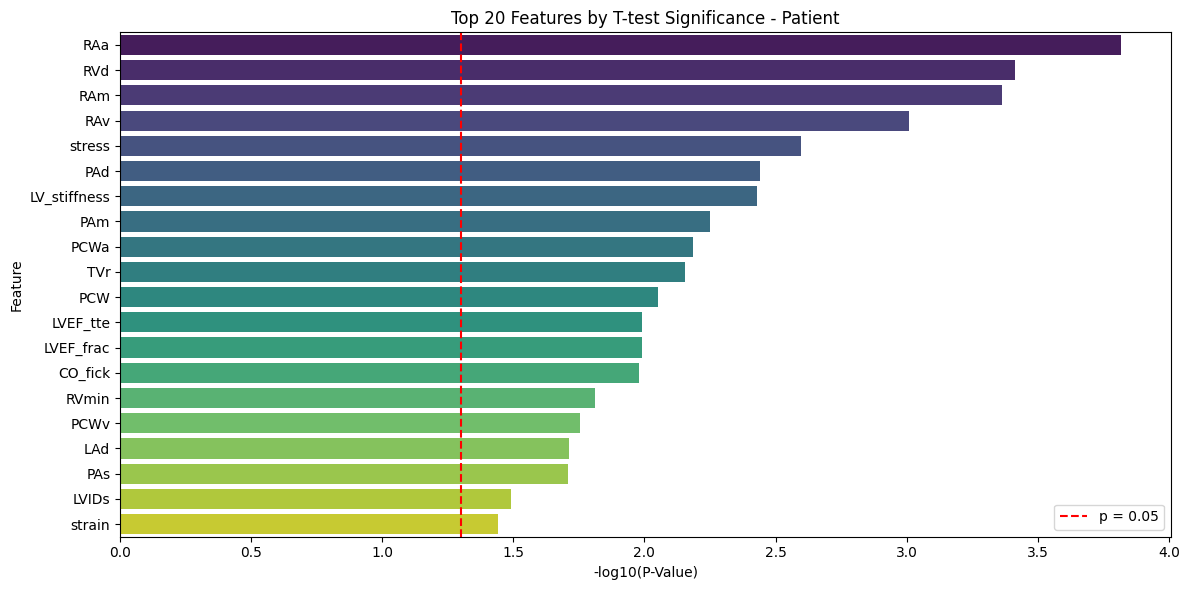

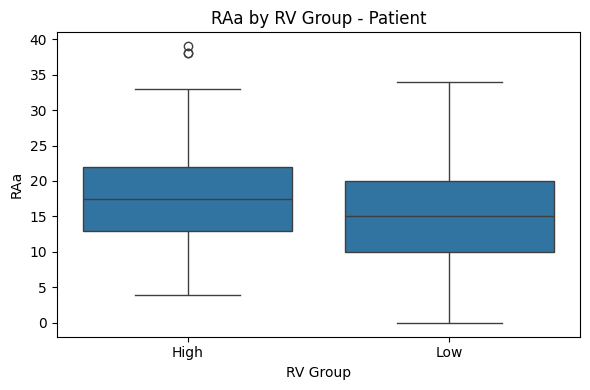

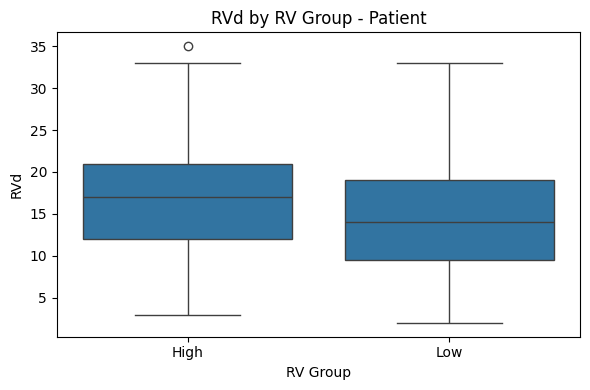

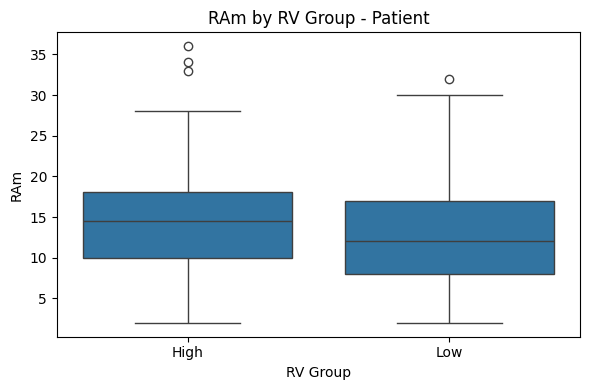


--- T-Test Results for Computational ---
C_SV: p = 0.0100 (significant)
k_pas_RV: p = 0.0097 (significant)
Vw_RV: p = 0.0050 (significant)
Amref_RV: p = 0.0087 (significant)
K1: p = 0.0408 (significant)
expPeri: p = 0.0171 (significant)
R_SA: p = 0.0402 (significant)
R_PA: p = 0.0087 (significant)
DBP_S: p = 0.0455 (significant)
RAPmean_S: p = 0.0008 (significant)
RAPmax_S: p = 0.0002 (significant)
RVEDP_S: p = 0.0028 (significant)
minRVP_S: p = 0.0078 (significant)
PASP_S: p = 0.0362 (significant)
PADP_S: p = 0.0024 (significant)
RVm_S: p = 0.0010 (significant)
CO_S: p = 0.0298 (significant)
EF_S: p = 0.0009 (significant)
RVEDV_S: p = 0.0001 (significant)
RVESV_S: p = 0.0000 (significant)
LVEDP_S: p = 0.0303 (significant)
minLVP_S: p = 0.0091 (significant)
TVr_S: p = 0.0000 (significant)
PVpg_S: p = 0.0257 (significant)
StressLV_S: p = 0.0068 (significant)
StrainLV_S: p = 0.0012 (significant)
StrainRV_S: p = 0.0000 (significant)
PVR_S: p = 0.0201 (significant)
LVEF_frac: p = 0.0009 (

/Users/pallakdhabalia/Documents/LVAD Project/env/lib/python3.13/site-packages/scipy/stats/_axis_nan_policy.py:586: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
/Users/pallakdhabalia/Documents/LVAD Project/env/lib/python3.13/site-packages/scipy/stats/_axis_nan_policy.py:586: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
/var/folders/dz/fbr6_yrs1qd7cqdgs7l6dw780000gn/T/ipykernel_93903/3222305105.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='-log10(P-Value)', y='Feature', data=pval_df.head(20), palet

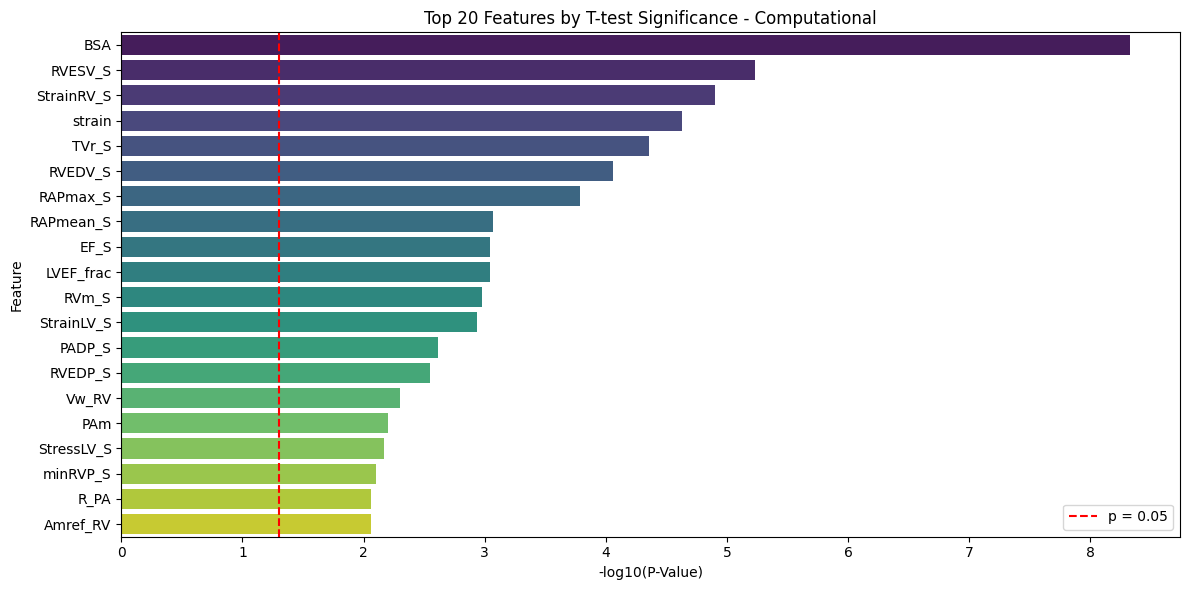

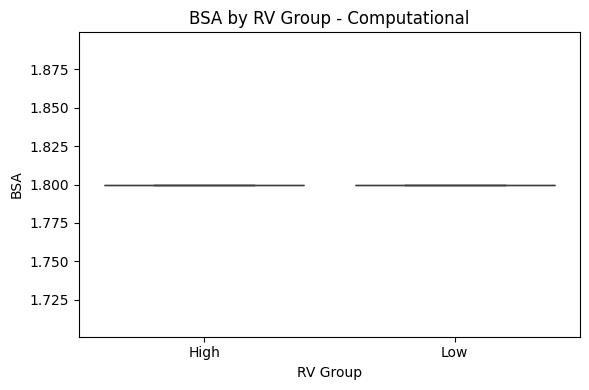

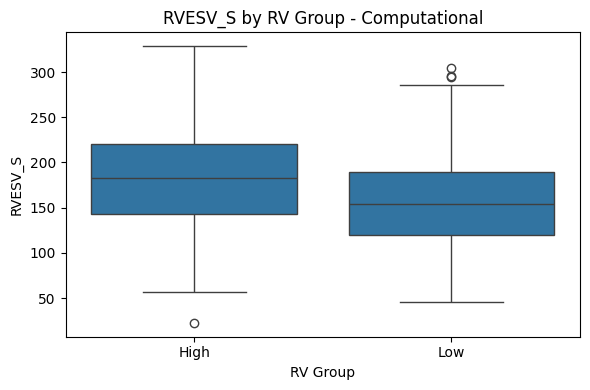

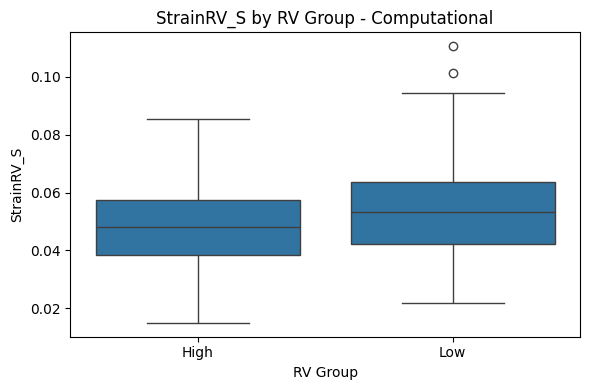


--- T-Test Results for Combined ---
CO_fick: p = 0.0151 (significant)
PCW: p = 0.0077 (significant)
PCWa: p = 0.0051 (significant)
PCWv: p = 0.0171 (significant)
PAs: p = 0.0192 (significant)
PAd: p = 0.0036 (significant)
RVmin: p = 0.0154 (significant)
RVd: p = 0.0004 (significant)
RAa: p = 0.0002 (significant)
RAv: p = 0.0010 (significant)
RAm: p = 0.0004 (significant)
LVIDd: p = 0.0468 (significant)
LVIDs: p = 0.0405 (significant)
LVEF_tte: p = 0.0110 (significant)
LAd: p = 0.0192 (significant)
MVr: p = 0.0388 (significant)
TVr: p = 0.0056 (significant)
Age: p = 0.0383 (significant)
C_SV: p = 0.0097 (significant)
k_pas_RV: p = 0.0099 (significant)
Vw_RV: p = 0.0046 (significant)
Amref_RV: p = 0.0086 (significant)
K1: p = 0.0416 (significant)
expPeri: p = 0.0174 (significant)
R_SA: p = 0.0436 (significant)
R_PA: p = 0.0087 (significant)
RAPmean_S: p = 0.0008 (significant)
RAPmax_S: p = 0.0002 (significant)
RVSP_S: p = 0.0494 (significant)
RVEDP_S: p = 0.0026 (significant)
minRVP_S: 

/Users/pallakdhabalia/Documents/LVAD Project/env/lib/python3.13/site-packages/scipy/stats/_stats_py.py:6153: RuntimeWarning: invalid value encountered in scalar subtract
  d = mean1 - mean2
/Users/pallakdhabalia/Documents/LVAD Project/env/lib/python3.13/site-packages/scipy/stats/_stats_py.py:6706: RuntimeWarning: invalid value encountered in scalar subtract
  estimate = m1 - m2
/Users/pallakdhabalia/Documents/LVAD Project/env/lib/python3.13/site-packages/scipy/stats/_stats_py.py:6153: RuntimeWarning: invalid value encountered in scalar subtract
  d = mean1 - mean2
/Users/pallakdhabalia/Documents/LVAD Project/env/lib/python3.13/site-packages/scipy/stats/_stats_py.py:6706: RuntimeWarning: invalid value encountered in scalar subtract
  estimate = m1 - m2
/var/folders/dz/fbr6_yrs1qd7cqdgs7l6dw780000gn/T/ipykernel_93903/3222305105.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=F

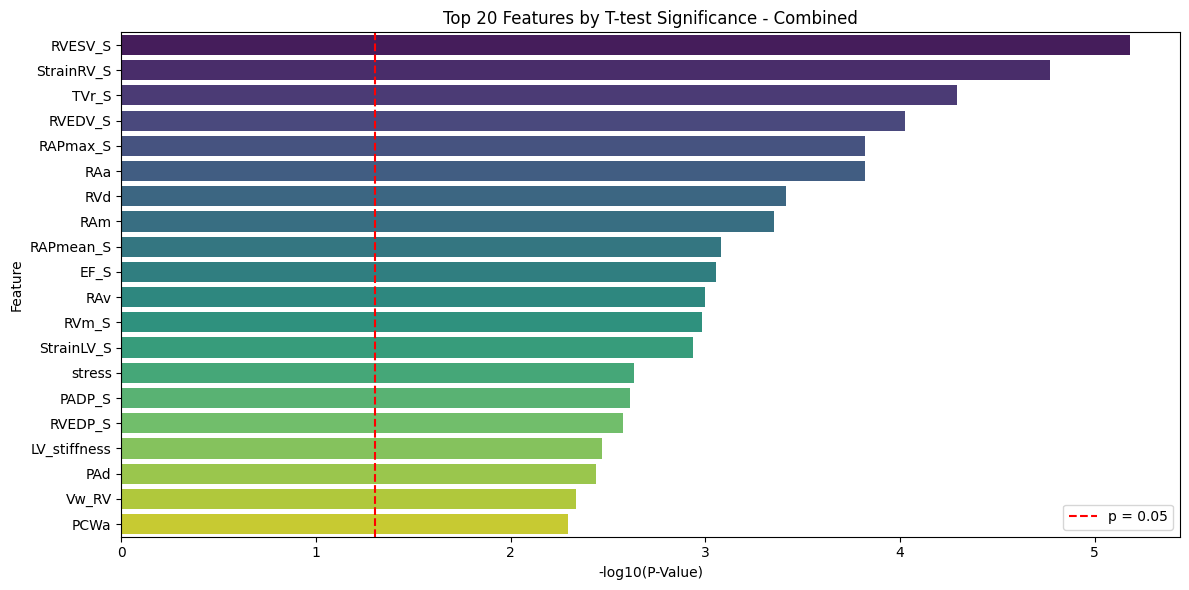

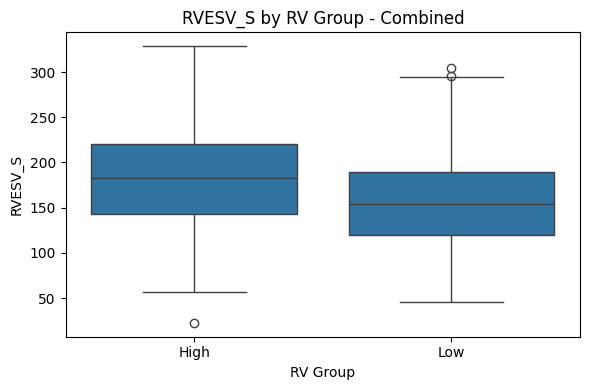

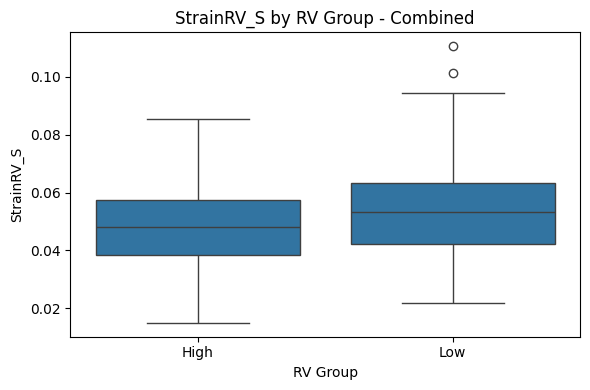

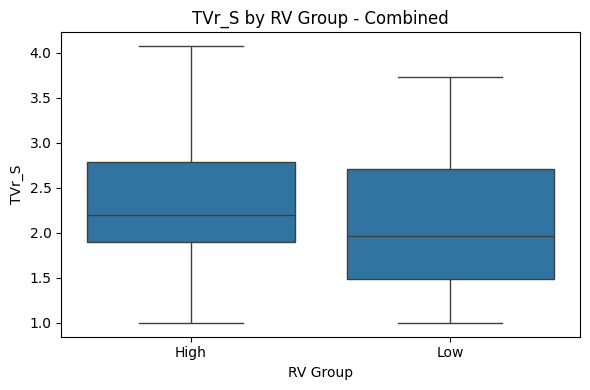

In [20]:
# === Run T-tests only ===
files = {
    'Patient': 'Close2AdmitDataWithRV.csv',
    'Computational': 'Close2AdmitDTinfo.csv',
    'Combined': 'CombinedDataWithRV.csv'
}

for label, path in files.items():
    df = preprocess_data(path)
    perform_t_tests(df, label)
    plot_ttest_pvalues(df, label)


In [ ]:
# === Run T-tests only ===
files = {
    'Patient': 'Close2AdmitDataWithRV.csv',
    'Computational': 'Close2AdmitDTinfo.csv',
    'Combined': 'CombinedDataWithRV.csv'
}

for label, path in files.items():
    df = preprocess_data(path)
    perform_t_tests(df, label)
    plot_boxplot(df, label)
